In [1]:
import pandas as pd  # pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##  XGBoost
https://www.kaggle.com/tilii7/xgboost-simple-starter-more-features

In [2]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import log_loss
from operator import itemgetter


/home/akos/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
df_train = pd.read_csv("../datasets/train1_50labels_withdaytimes_app60000.csv", sep=",")
#df_train = df_train.set_index("device_id")
#df_train.drop(columns=["Unnamed: 0"], inplace=True)
df_train.head(1)

,Unnamed: 0,device_id,events_num,min_timestamp,max_timestamp,latitude_events_median,longitude_events_median,events_per_day,label_548,label_i_548,...,app_9136721329817567486,app_-2145434552412465677,app_6868430133575209713,app_5824972015480403938,gender,age,group,phone_brand,device_model,phone_brand_eng
0,0,-8076087639492063270,0,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,M,35,M32-38,小米,MI 2,Xiaomi


In [4]:
# factorize
if True:
    factor = pd.factorize(df_train['phone_brand_eng'])
    df_train.phone_brand_eng = factor[0]
    definitions_phone_brand_eng = factor[1]
    factor = pd.factorize(df_train['device_model'])
    df_train.device_model = factor[0]
    definitions_device_model = factor[1]
    factor = pd.factorize(df_train['group'])
    df_train.group = factor[0]
    definitions = factor[1]

In [5]:
df_train_events=df_train[df_train["events_num"] > 0]
df_train_noevents=df_train[df_train["events_num"] == 0][["phone_brand_eng", "device_model", "group"]]
df_train_noevents.head(1)

,phone_brand_eng,device_model,group
0,0,0,0


In [6]:
def doXGB(df_train, magyarazo_valtozok, max_depth=10, num_boost_round = 400):

    
    # split
    X_train, X_test, y_train, y_test = train_test_split(df_train[magyarazo_valtozok], df_train['group'], test_size=0.2,random_state=109) # 90% training and 10% test
    
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_test, y_test)
    
    # params
    eta = 0.025
    subsample = 0.75
    colsample_bytree = 0.75
    random_state=123
    params = {
            "objective": "multi:softprob",
            "num_class": 12,
            "booster" : "gbtree",
            "eval_metric": "mlogloss",
            "eta": eta,
            "max_depth": max_depth,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "silent": 1,
            "seed": random_state,
        } 
    
    # model
    early_stopping_rounds = 20

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    check = gbm.predict(xgb.DMatrix(X_test), ntree_limit=gbm.best_iteration)
    score = log_loss(y_test.tolist(), check)
    
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(magyarazo_valtozok):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    
    p = metrics.accuracy_score(y_test, np.argmax(check, axis=1))
    
    return importance, score, p, check

    

In [7]:
results = {}


In [8]:
magyarazo_valtozok_app_label = []
for m in df_train.columns:
    if m not in ['Unnamed: 0', 'device_id', 'min_timestamp', 'max_timestamp','gender', 'age', 'group', 'phone_brand' ]:
        magyarazo_valtozok_app_label += [m]

magyarazo_valtozok_app_label_a = []
for m in df_train.columns:
    if m not in ['Unnamed: 0', 'device_id', 'min_timestamp', 'max_timestamp','gender', 'age', 'group', 'phone_brand' ]:
        if m.startswith("label_i_"):
            continue
        magyarazo_valtozok_app_label_a += [m]

        
magyarazo_valtozok_app = []
for m in df_train.columns:
    if m not in ['Unnamed: 0', 'device_id', 'min_timestamp', 'max_timestamp','gender', 'age', 'group', 'phone_brand' ]:
        if m.startswith("label_"):
            continue
        magyarazo_valtozok_app += [m]

magyarazo_valtozok_label = []
for m in df_train.columns:
    if m not in ['Unnamed: 0', 'device_id', 'min_timestamp', 'max_timestamp','gender', 'age', 'group', 'phone_brand' ]:
        if m.startswith("app_"):
            continue
        magyarazo_valtozok_label += [m]

magyarazo_valtozok_nolabel_noapp = []
for m in df_train.columns:
    if m not in ['Unnamed: 0', 'device_id', 'min_timestamp', 'max_timestamp','gender', 'age', 'group', 'phone_brand' ]:
        if m.startswith("app_"):
            continue
        if m.startswith("label_"):
            continue            
        magyarazo_valtozok_nolabel_noapp += [m]

        
        
magyarazo_valtozok_no_events = []
for m in df_train_noevents.columns:
    if m not in ['Unnamed: 0', 'device_id', 'min_timestamp', 'max_timestamp','gender', 'age', 'group', 'phone_brand' ]:
        magyarazo_valtozok_no_events += [m]



In [9]:
results={}
results["NoEvent, Event - Label:yes, App:yes"] = (doXGB(df_train, magyarazo_valtozok_app_label))
results["NoEvent, Event - Label:yes (only a), App:yes"] = (doXGB(df_train, magyarazo_valtozok_app_label_a))
results["NoEvent, Event - Label:no, App:yes"] = (doXGB(df_train, magyarazo_valtozok_app))
results["NoEvent, Event - Label:yes, App:no"] = (doXGB(df_train, magyarazo_valtozok_label))
results["NoEvent, Event - Label:no, App:no"] = (doXGB(df_train, magyarazo_valtozok_nolabel_noapp))
results["Event - Label:yes, App:yes"] = (doXGB(df_train_events, magyarazo_valtozok_app_label))
results["Event - Label:no, App:yes"] = (doXGB(df_train_events, magyarazo_valtozok_app))
results["Event - Label:yes, App:no"] = (doXGB(df_train_events, magyarazo_valtozok_label))
results["Event - Label:no, App:no"] = (doXGB(df_train_events, magyarazo_valtozok_nolabel_noapp))
results["NoEvent"] = (doXGB(df_train_noevents, magyarazo_valtozok_no_events))


/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.47644	eval-mlogloss:2.48124
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.46839	eval-mlogloss:2.47781
[2]	train-mlogloss:2.46028	eval-mlogloss:2.47435
[3]	train-mlogloss:2.45255	eval-mlogloss:2.47111
[4]	train-mlogloss:2.445	eval-mlogloss:2.46798
[5]	train-mlogloss:2.43769	eval-mlogloss:2.46494
[6]	train-mlogloss:2.43024	eval-mlogloss:2.46193
[7]	train-mlogloss:2.42286	eval-mlogloss:2.45908
[8]	train-mlogloss:2.4159	eval-mlogloss:2.4564
[9]	train-mlogloss:2.40906	eval-mlogloss:2.45371
[10]	train-mlogloss:2.40225	eval-mlogloss:2.451
[11]	train-mlogloss:2.39561	eval-mlogloss:2.44834
[12]	train-mlogloss:2.38899	eval-mlogloss:2.44582
[13]	train-mlogloss:2.38259	eval-mlogloss:2.44346
[14]	train-mlogloss:2.37628	eval-mlogloss:2.44114
[15]	train-mlogloss:2.37017	eval-mlogloss:2.43887
[16]	train-mlogloss:2.3642	eval-mlogloss:2.43662
[17]	train-mlogl

[161]	train-mlogloss:1.97029	eval-mlogloss:2.33834
[162]	train-mlogloss:1.96894	eval-mlogloss:2.33815
[163]	train-mlogloss:1.96779	eval-mlogloss:2.33795
[164]	train-mlogloss:1.96649	eval-mlogloss:2.33777
[165]	train-mlogloss:1.96517	eval-mlogloss:2.33761
[166]	train-mlogloss:1.9637	eval-mlogloss:2.3374
[167]	train-mlogloss:1.96246	eval-mlogloss:2.33729
[168]	train-mlogloss:1.96124	eval-mlogloss:2.33714
[169]	train-mlogloss:1.96007	eval-mlogloss:2.337
[170]	train-mlogloss:1.95883	eval-mlogloss:2.33687
[171]	train-mlogloss:1.95756	eval-mlogloss:2.33674
[172]	train-mlogloss:1.9564	eval-mlogloss:2.33657
[173]	train-mlogloss:1.95532	eval-mlogloss:2.33645
[174]	train-mlogloss:1.95394	eval-mlogloss:2.3363
[175]	train-mlogloss:1.95261	eval-mlogloss:2.33617
[176]	train-mlogloss:1.95124	eval-mlogloss:2.336
[177]	train-mlogloss:1.95008	eval-mlogloss:2.33592
[178]	train-mlogloss:1.94907	eval-mlogloss:2.33574
[179]	train-mlogloss:1.94796	eval-mlogloss:2.33557
[180]	train-mlogloss:1.94664	eval-mlogl

[323]	train-mlogloss:1.82119	eval-mlogloss:2.32541
[324]	train-mlogloss:1.82042	eval-mlogloss:2.32538
[325]	train-mlogloss:1.81962	eval-mlogloss:2.32536
[326]	train-mlogloss:1.81901	eval-mlogloss:2.32532
[327]	train-mlogloss:1.81838	eval-mlogloss:2.32531
[328]	train-mlogloss:1.81771	eval-mlogloss:2.32527
[329]	train-mlogloss:1.8171	eval-mlogloss:2.32529
[330]	train-mlogloss:1.81654	eval-mlogloss:2.32529
[331]	train-mlogloss:1.8159	eval-mlogloss:2.32529
[332]	train-mlogloss:1.81521	eval-mlogloss:2.32523
[333]	train-mlogloss:1.81469	eval-mlogloss:2.32524
[334]	train-mlogloss:1.81406	eval-mlogloss:2.32523
[335]	train-mlogloss:1.81345	eval-mlogloss:2.32522
[336]	train-mlogloss:1.81299	eval-mlogloss:2.32523
[337]	train-mlogloss:1.81225	eval-mlogloss:2.32519
[338]	train-mlogloss:1.8117	eval-mlogloss:2.32519
[339]	train-mlogloss:1.81121	eval-mlogloss:2.32516
[340]	train-mlogloss:1.81061	eval-mlogloss:2.32513
[341]	train-mlogloss:1.80998	eval-mlogloss:2.32515
[342]	train-mlogloss:1.80933	eval-

/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.47743	eval-mlogloss:2.48148
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.47003	eval-mlogloss:2.47802
[2]	train-mlogloss:2.46295	eval-mlogloss:2.47465
[3]	train-mlogloss:2.45614	eval-mlogloss:2.47144
[4]	train-mlogloss:2.44925	eval-mlogloss:2.46832
[5]	train-mlogloss:2.44265	eval-mlogloss:2.46546
[6]	train-mlogloss:2.43602	eval-mlogloss:2.46264
[7]	train-mlogloss:2.42946	eval-mlogloss:2.45973
[8]	train-mlogloss:2.42335	eval-mlogloss:2.45698
[9]	train-mlogloss:2.41712	eval-mlogloss:2.45444
[10]	train-mlogloss:2.41105	eval-mlogloss:2.45173
[11]	train-mlogloss:2.40501	eval-mlogloss:2.44934
[12]	train-mlogloss:2.3992	eval-mlogloss:2.44684
[13]	train-mlogloss:2.39353	eval-mlogloss:2.4444
[14]	train-mlogloss:2.38793	eval-mlogloss:2.44204
[15]	train-mlogloss:2.38231	eval-mlogloss:2.43989
[16]	train-mlogloss:2.37679	eval-mlogloss:2.4376
[17]	train-m

[161]	train-mlogloss:2.01652	eval-mlogloss:2.34102
[162]	train-mlogloss:2.01531	eval-mlogloss:2.34082
[163]	train-mlogloss:2.01416	eval-mlogloss:2.34069
[164]	train-mlogloss:2.01282	eval-mlogloss:2.34054
[165]	train-mlogloss:2.01151	eval-mlogloss:2.34044
[166]	train-mlogloss:2.01022	eval-mlogloss:2.34026
[167]	train-mlogloss:2.00908	eval-mlogloss:2.34018
[168]	train-mlogloss:2.00792	eval-mlogloss:2.33999
[169]	train-mlogloss:2.00673	eval-mlogloss:2.33983
[170]	train-mlogloss:2.00561	eval-mlogloss:2.33966
[171]	train-mlogloss:2.00441	eval-mlogloss:2.33949
[172]	train-mlogloss:2.00313	eval-mlogloss:2.33935
[173]	train-mlogloss:2.00203	eval-mlogloss:2.33918
[174]	train-mlogloss:2.00086	eval-mlogloss:2.33905
[175]	train-mlogloss:1.99963	eval-mlogloss:2.33896
[176]	train-mlogloss:1.99858	eval-mlogloss:2.33886
[177]	train-mlogloss:1.99754	eval-mlogloss:2.33876
[178]	train-mlogloss:1.99632	eval-mlogloss:2.33865
[179]	train-mlogloss:1.99519	eval-mlogloss:2.33849
[180]	train-mlogloss:1.99403	ev

[323]	train-mlogloss:1.86943	eval-mlogloss:2.32843
[324]	train-mlogloss:1.86875	eval-mlogloss:2.32847
[325]	train-mlogloss:1.86804	eval-mlogloss:2.32845
[326]	train-mlogloss:1.86733	eval-mlogloss:2.32848
[327]	train-mlogloss:1.86654	eval-mlogloss:2.32847
[328]	train-mlogloss:1.8659	eval-mlogloss:2.32843
[329]	train-mlogloss:1.86531	eval-mlogloss:2.32843
[330]	train-mlogloss:1.8647	eval-mlogloss:2.3284
[331]	train-mlogloss:1.86407	eval-mlogloss:2.32836
[332]	train-mlogloss:1.86338	eval-mlogloss:2.32834
[333]	train-mlogloss:1.86272	eval-mlogloss:2.32833
[334]	train-mlogloss:1.86203	eval-mlogloss:2.32831
[335]	train-mlogloss:1.8614	eval-mlogloss:2.32833
[336]	train-mlogloss:1.86075	eval-mlogloss:2.32827
[337]	train-mlogloss:1.86002	eval-mlogloss:2.3282
[338]	train-mlogloss:1.85938	eval-mlogloss:2.32816
[339]	train-mlogloss:1.85871	eval-mlogloss:2.32814
[340]	train-mlogloss:1.858	eval-mlogloss:2.32811
[341]	train-mlogloss:1.8573	eval-mlogloss:2.32808
[342]	train-mlogloss:1.85661	eval-mlogl

/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.47815	eval-mlogloss:2.48147
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.47148	eval-mlogloss:2.47822
[2]	train-mlogloss:2.46507	eval-mlogloss:2.4749
[3]	train-mlogloss:2.45906	eval-mlogloss:2.47194
[4]	train-mlogloss:2.4527	eval-mlogloss:2.4688
[5]	train-mlogloss:2.44651	eval-mlogloss:2.46578
[6]	train-mlogloss:2.44067	eval-mlogloss:2.4629
[7]	train-mlogloss:2.43487	eval-mlogloss:2.46014
[8]	train-mlogloss:2.42924	eval-mlogloss:2.45732
[9]	train-mlogloss:2.42364	eval-mlogloss:2.45463
[10]	train-mlogloss:2.41816	eval-mlogloss:2.45194
[11]	train-mlogloss:2.4128	eval-mlogloss:2.44956
[12]	train-mlogloss:2.40777	eval-mlogloss:2.44728
[13]	train-mlogloss:2.40268	eval-mlogloss:2.44477
[14]	train-mlogloss:2.39756	eval-mlogloss:2.44249
[15]	train-mlogloss:2.39272	eval-mlogloss:2.44042
[16]	train-mlogloss:2.38778	eval-mlogloss:2.43815
[17]	train-mlo

[161]	train-mlogloss:2.05911	eval-mlogloss:2.34124
[162]	train-mlogloss:2.05801	eval-mlogloss:2.34109
[163]	train-mlogloss:2.057	eval-mlogloss:2.34099
[164]	train-mlogloss:2.05576	eval-mlogloss:2.34084
[165]	train-mlogloss:2.05459	eval-mlogloss:2.34068
[166]	train-mlogloss:2.05346	eval-mlogloss:2.34048
[167]	train-mlogloss:2.05233	eval-mlogloss:2.34031
[168]	train-mlogloss:2.05134	eval-mlogloss:2.34012
[169]	train-mlogloss:2.05019	eval-mlogloss:2.33996
[170]	train-mlogloss:2.04915	eval-mlogloss:2.33979
[171]	train-mlogloss:2.04808	eval-mlogloss:2.33972
[172]	train-mlogloss:2.04703	eval-mlogloss:2.33959
[173]	train-mlogloss:2.04596	eval-mlogloss:2.33948
[174]	train-mlogloss:2.04491	eval-mlogloss:2.33934
[175]	train-mlogloss:2.04372	eval-mlogloss:2.33928
[176]	train-mlogloss:2.04266	eval-mlogloss:2.33918
[177]	train-mlogloss:2.04159	eval-mlogloss:2.33909
[178]	train-mlogloss:2.04056	eval-mlogloss:2.33899
[179]	train-mlogloss:2.03965	eval-mlogloss:2.33886
[180]	train-mlogloss:2.03869	eval

[323]	train-mlogloss:1.92197	eval-mlogloss:2.32913
[324]	train-mlogloss:1.92127	eval-mlogloss:2.3291
[325]	train-mlogloss:1.92048	eval-mlogloss:2.32908
[326]	train-mlogloss:1.91987	eval-mlogloss:2.32908
[327]	train-mlogloss:1.91915	eval-mlogloss:2.329
[328]	train-mlogloss:1.91858	eval-mlogloss:2.329
[329]	train-mlogloss:1.91799	eval-mlogloss:2.32897
[330]	train-mlogloss:1.91749	eval-mlogloss:2.32893
[331]	train-mlogloss:1.91695	eval-mlogloss:2.32889
[332]	train-mlogloss:1.91633	eval-mlogloss:2.32884
[333]	train-mlogloss:1.91563	eval-mlogloss:2.32886
[334]	train-mlogloss:1.91494	eval-mlogloss:2.32879
[335]	train-mlogloss:1.91434	eval-mlogloss:2.32876
[336]	train-mlogloss:1.91378	eval-mlogloss:2.32872
[337]	train-mlogloss:1.91324	eval-mlogloss:2.3287
[338]	train-mlogloss:1.91265	eval-mlogloss:2.32869
[339]	train-mlogloss:1.91215	eval-mlogloss:2.32868
[340]	train-mlogloss:1.91162	eval-mlogloss:2.32868
[341]	train-mlogloss:1.91096	eval-mlogloss:2.32866
[342]	train-mlogloss:1.91034	eval-mlo

/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.47646	eval-mlogloss:2.48185
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.46817	eval-mlogloss:2.47873
[2]	train-mlogloss:2.46004	eval-mlogloss:2.4758
[3]	train-mlogloss:2.4522	eval-mlogloss:2.4729
[4]	train-mlogloss:2.44473	eval-mlogloss:2.46998
[5]	train-mlogloss:2.43685	eval-mlogloss:2.46706
[6]	train-mlogloss:2.42941	eval-mlogloss:2.46442
[7]	train-mlogloss:2.42215	eval-mlogloss:2.46197
[8]	train-mlogloss:2.41513	eval-mlogloss:2.45958
[9]	train-mlogloss:2.40793	eval-mlogloss:2.45711
[10]	train-mlogloss:2.40094	eval-mlogloss:2.45476
[11]	train-mlogloss:2.39445	eval-mlogloss:2.45252
[12]	train-mlogloss:2.38771	eval-mlogloss:2.45029
[13]	train-mlogloss:2.38118	eval-mlogloss:2.44821
[14]	train-mlogloss:2.37466	eval-mlogloss:2.44614
[15]	train-mlogloss:2.36849	eval-mlogloss:2.44405
[16]	train-mlogloss:2.36207	eval-mlogloss:2.44212
[17]	train-m

[161]	train-mlogloss:1.94614	eval-mlogloss:2.36153
[162]	train-mlogloss:1.94488	eval-mlogloss:2.36143
[163]	train-mlogloss:1.94363	eval-mlogloss:2.3613
[164]	train-mlogloss:1.9423	eval-mlogloss:2.36117
[165]	train-mlogloss:1.94097	eval-mlogloss:2.36106
[166]	train-mlogloss:1.93968	eval-mlogloss:2.361
[167]	train-mlogloss:1.93833	eval-mlogloss:2.36091
[168]	train-mlogloss:1.93713	eval-mlogloss:2.36079
[169]	train-mlogloss:1.93573	eval-mlogloss:2.36072
[170]	train-mlogloss:1.9345	eval-mlogloss:2.36066
[171]	train-mlogloss:1.93334	eval-mlogloss:2.36058
[172]	train-mlogloss:1.93225	eval-mlogloss:2.36048
[173]	train-mlogloss:1.93116	eval-mlogloss:2.36042
[174]	train-mlogloss:1.9298	eval-mlogloss:2.36032
[175]	train-mlogloss:1.92851	eval-mlogloss:2.36029
[176]	train-mlogloss:1.92732	eval-mlogloss:2.36023
[177]	train-mlogloss:1.92603	eval-mlogloss:2.36019
[178]	train-mlogloss:1.92492	eval-mlogloss:2.36016
[179]	train-mlogloss:1.92359	eval-mlogloss:2.36009
[180]	train-mlogloss:1.92242	eval-mlo

[323]	train-mlogloss:1.8012	eval-mlogloss:2.35744
[324]	train-mlogloss:1.80061	eval-mlogloss:2.35742
[325]	train-mlogloss:1.79998	eval-mlogloss:2.35744
[326]	train-mlogloss:1.79935	eval-mlogloss:2.35747
[327]	train-mlogloss:1.79875	eval-mlogloss:2.35747
[328]	train-mlogloss:1.79815	eval-mlogloss:2.3575
[329]	train-mlogloss:1.79747	eval-mlogloss:2.35751
[330]	train-mlogloss:1.79691	eval-mlogloss:2.35752
[331]	train-mlogloss:1.79631	eval-mlogloss:2.35754
[332]	train-mlogloss:1.79572	eval-mlogloss:2.35753
Stopping. Best iteration:
[312]	train-mlogloss:1.80817	eval-mlogloss:2.3573



/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.47947	eval-mlogloss:2.48225
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.47423	eval-mlogloss:2.47979
[2]	train-mlogloss:2.46861	eval-mlogloss:2.47725
[3]	train-mlogloss:2.46353	eval-mlogloss:2.47508
[4]	train-mlogloss:2.45838	eval-mlogloss:2.47278
[5]	train-mlogloss:2.45369	eval-mlogloss:2.47078
[6]	train-mlogloss:2.4487	eval-mlogloss:2.46861
[7]	train-mlogloss:2.44396	eval-mlogloss:2.46655
[8]	train-mlogloss:2.43947	eval-mlogloss:2.46471
[9]	train-mlogloss:2.43481	eval-mlogloss:2.46273
[10]	train-mlogloss:2.43023	eval-mlogloss:2.46074
[11]	train-mlogloss:2.42596	eval-mlogloss:2.45891
[12]	train-mlogloss:2.42163	eval-mlogloss:2.45716
[13]	train-mlogloss:2.4176	eval-mlogloss:2.45551
[14]	train-mlogloss:2.41332	eval-mlogloss:2.45375
[15]	train-mlogloss:2.40926	eval-mlogloss:2.45217
[16]	train-mlogloss:2.40534	eval-mlogloss:2.45061
[17]	train-

[161]	train-mlogloss:2.12665	eval-mlogloss:2.39595
[162]	train-mlogloss:2.12581	eval-mlogloss:2.39596
[163]	train-mlogloss:2.12481	eval-mlogloss:2.396
[164]	train-mlogloss:2.12378	eval-mlogloss:2.39596
[165]	train-mlogloss:2.12282	eval-mlogloss:2.39595
[166]	train-mlogloss:2.12191	eval-mlogloss:2.39597
[167]	train-mlogloss:2.12091	eval-mlogloss:2.39593
[168]	train-mlogloss:2.11998	eval-mlogloss:2.39598
[169]	train-mlogloss:2.11918	eval-mlogloss:2.39596
[170]	train-mlogloss:2.1182	eval-mlogloss:2.39592
[171]	train-mlogloss:2.11727	eval-mlogloss:2.39594
[172]	train-mlogloss:2.11635	eval-mlogloss:2.39594
[173]	train-mlogloss:2.1154	eval-mlogloss:2.39596
[174]	train-mlogloss:2.11446	eval-mlogloss:2.39599
[175]	train-mlogloss:2.11353	eval-mlogloss:2.39595
[176]	train-mlogloss:2.11271	eval-mlogloss:2.39596
[177]	train-mlogloss:2.11188	eval-mlogloss:2.39601
[178]	train-mlogloss:2.11117	eval-mlogloss:2.39601
[179]	train-mlogloss:2.11012	eval-mlogloss:2.39606
[180]	train-mlogloss:2.10921	eval-m

/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.46198	eval-mlogloss:2.47763
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.43976	eval-mlogloss:2.47113
[2]	train-mlogloss:2.41844	eval-mlogloss:2.46507
[3]	train-mlogloss:2.39726	eval-mlogloss:2.45844
[4]	train-mlogloss:2.37716	eval-mlogloss:2.45266
[5]	train-mlogloss:2.35737	eval-mlogloss:2.44694
[6]	train-mlogloss:2.33839	eval-mlogloss:2.44111
[7]	train-mlogloss:2.31924	eval-mlogloss:2.43525
[8]	train-mlogloss:2.30001	eval-mlogloss:2.43023
[9]	train-mlogloss:2.28046	eval-mlogloss:2.42444
[10]	train-mlogloss:2.26175	eval-mlogloss:2.41931
[11]	train-mlogloss:2.24354	eval-mlogloss:2.41407
[12]	train-mlogloss:2.22568	eval-mlogloss:2.40937
[13]	train-mlogloss:2.20814	eval-mlogloss:2.40488
[14]	train-mlogloss:2.19089	eval-mlogloss:2.40036
[15]	train-mlogloss:2.17431	eval-mlogloss:2.39599
[16]	train-mlogloss:2.15837	eval-mlogloss:2.39177
[17]	trai

[161]	train-mlogloss:0.999925	eval-mlogloss:2.189
[162]	train-mlogloss:0.995621	eval-mlogloss:2.18859
[163]	train-mlogloss:0.991635	eval-mlogloss:2.18818
[164]	train-mlogloss:0.98745	eval-mlogloss:2.18799
[165]	train-mlogloss:0.983114	eval-mlogloss:2.18762
[166]	train-mlogloss:0.979057	eval-mlogloss:2.18736
[167]	train-mlogloss:0.975334	eval-mlogloss:2.18707
[168]	train-mlogloss:0.970822	eval-mlogloss:2.18678
[169]	train-mlogloss:0.966409	eval-mlogloss:2.18633
[170]	train-mlogloss:0.962298	eval-mlogloss:2.18593
[171]	train-mlogloss:0.958193	eval-mlogloss:2.1856
[172]	train-mlogloss:0.954466	eval-mlogloss:2.18525
[173]	train-mlogloss:0.95084	eval-mlogloss:2.18495
[174]	train-mlogloss:0.947306	eval-mlogloss:2.18458
[175]	train-mlogloss:0.943219	eval-mlogloss:2.18407
[176]	train-mlogloss:0.939436	eval-mlogloss:2.18399
[177]	train-mlogloss:0.935402	eval-mlogloss:2.18373
[178]	train-mlogloss:0.931073	eval-mlogloss:2.18344
[179]	train-mlogloss:0.927261	eval-mlogloss:2.18311
[180]	train-mlogl

[320]	train-mlogloss:0.542054	eval-mlogloss:2.16533
[321]	train-mlogloss:0.540315	eval-mlogloss:2.16537
[322]	train-mlogloss:0.538223	eval-mlogloss:2.16539
[323]	train-mlogloss:0.535918	eval-mlogloss:2.16523
[324]	train-mlogloss:0.533924	eval-mlogloss:2.16535
[325]	train-mlogloss:0.532182	eval-mlogloss:2.16528
[326]	train-mlogloss:0.530346	eval-mlogloss:2.16525
[327]	train-mlogloss:0.528947	eval-mlogloss:2.16512
[328]	train-mlogloss:0.526669	eval-mlogloss:2.16517
[329]	train-mlogloss:0.524897	eval-mlogloss:2.16517
Stopping. Best iteration:
[309]	train-mlogloss:0.564452	eval-mlogloss:2.16469



/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.46804	eval-mlogloss:2.47883
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.45165	eval-mlogloss:2.47224
[2]	train-mlogloss:2.43556	eval-mlogloss:2.46613
[3]	train-mlogloss:2.41978	eval-mlogloss:2.46012
[4]	train-mlogloss:2.40434	eval-mlogloss:2.45413
[5]	train-mlogloss:2.38909	eval-mlogloss:2.44868
[6]	train-mlogloss:2.37346	eval-mlogloss:2.44308
[7]	train-mlogloss:2.35831	eval-mlogloss:2.43773
[8]	train-mlogloss:2.34398	eval-mlogloss:2.4331
[9]	train-mlogloss:2.32983	eval-mlogloss:2.42803
[10]	train-mlogloss:2.31669	eval-mlogloss:2.42285
[11]	train-mlogloss:2.30325	eval-mlogloss:2.41822
[12]	train-mlogloss:2.2897	eval-mlogloss:2.41301
[13]	train-mlogloss:2.27684	eval-mlogloss:2.40902
[14]	train-mlogloss:2.26399	eval-mlogloss:2.4048
[15]	train-mlogloss:2.25139	eval-mlogloss:2.40061
[16]	train-mlogloss:2.23912	eval-mlogloss:2.39665
[17]	train-m

[161]	train-mlogloss:1.32281	eval-mlogloss:2.20149
[162]	train-mlogloss:1.31907	eval-mlogloss:2.20106
[163]	train-mlogloss:1.31584	eval-mlogloss:2.20069
[164]	train-mlogloss:1.31181	eval-mlogloss:2.20039
[165]	train-mlogloss:1.30837	eval-mlogloss:2.2001
[166]	train-mlogloss:1.30453	eval-mlogloss:2.19972
[167]	train-mlogloss:1.30109	eval-mlogloss:2.19932
[168]	train-mlogloss:1.29746	eval-mlogloss:2.19896
[169]	train-mlogloss:1.2939	eval-mlogloss:2.19852
[170]	train-mlogloss:1.29065	eval-mlogloss:2.19804
[171]	train-mlogloss:1.28709	eval-mlogloss:2.19783
[172]	train-mlogloss:1.28371	eval-mlogloss:2.19764
[173]	train-mlogloss:1.28051	eval-mlogloss:2.19737
[174]	train-mlogloss:1.27744	eval-mlogloss:2.1971
[175]	train-mlogloss:1.2742	eval-mlogloss:2.1968
[176]	train-mlogloss:1.27099	eval-mlogloss:2.19659
[177]	train-mlogloss:1.26751	eval-mlogloss:2.19621
[178]	train-mlogloss:1.26438	eval-mlogloss:2.19589
[179]	train-mlogloss:1.26076	eval-mlogloss:2.19542
[180]	train-mlogloss:1.25778	eval-ml

[322]	train-mlogloss:0.902633	eval-mlogloss:2.17782
[323]	train-mlogloss:0.900421	eval-mlogloss:2.17777
[324]	train-mlogloss:0.898603	eval-mlogloss:2.1778
[325]	train-mlogloss:0.896515	eval-mlogloss:2.17763
[326]	train-mlogloss:0.894817	eval-mlogloss:2.17765
[327]	train-mlogloss:0.893223	eval-mlogloss:2.17764
[328]	train-mlogloss:0.890917	eval-mlogloss:2.17769
[329]	train-mlogloss:0.88926	eval-mlogloss:2.17767
[330]	train-mlogloss:0.887311	eval-mlogloss:2.17768
[331]	train-mlogloss:0.885695	eval-mlogloss:2.17766
[332]	train-mlogloss:0.884006	eval-mlogloss:2.17761
[333]	train-mlogloss:0.882154	eval-mlogloss:2.17774
[334]	train-mlogloss:0.880376	eval-mlogloss:2.17774
[335]	train-mlogloss:0.878692	eval-mlogloss:2.17765
[336]	train-mlogloss:0.876496	eval-mlogloss:2.17757
[337]	train-mlogloss:0.874209	eval-mlogloss:2.17757
[338]	train-mlogloss:0.872276	eval-mlogloss:2.17759
[339]	train-mlogloss:0.870278	eval-mlogloss:2.17764
[340]	train-mlogloss:0.867999	eval-mlogloss:2.17774
[341]	train-ml

/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:2.46302	eval-mlogloss:2.47892
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.44089	eval-mlogloss:2.4733
[2]	train-mlogloss:2.41947	eval-mlogloss:2.46759
[3]	train-mlogloss:2.39884	eval-mlogloss:2.46258
[4]	train-mlogloss:2.37781	eval-mlogloss:2.45761
[5]	train-mlogloss:2.3569	eval-mlogloss:2.45282
[6]	train-mlogloss:2.3366	eval-mlogloss:2.44823
[7]	train-mlogloss:2.31672	eval-mlogloss:2.44372
[8]	train-mlogloss:2.29712	eval-mlogloss:2.43902
[9]	train-mlogloss:2.27754	eval-mlogloss:2.43452
[10]	train-mlogloss:2.25875	eval-mlogloss:2.43053
[11]	train-mlogloss:2.24011	eval-mlogloss:2.42636
[12]	train-mlogloss:2.2217	eval-mlogloss:2.42268
[13]	train-mlogloss:2.20367	eval-mlogloss:2.41897
[14]	train-mlogloss:2.1859	eval-mlogloss:2.4151
[15]	train-mlogloss:2.16874	eval-mlogloss:2.41174
[16]	train-mlogloss:2.15148	eval-mlogloss:2.40798
[17]	train-mlog

[161]	train-mlogloss:0.9148	eval-mlogloss:2.25795
[162]	train-mlogloss:0.910195	eval-mlogloss:2.25777
[163]	train-mlogloss:0.906247	eval-mlogloss:2.25762
[164]	train-mlogloss:0.901913	eval-mlogloss:2.25729
[165]	train-mlogloss:0.897834	eval-mlogloss:2.25707
[166]	train-mlogloss:0.893599	eval-mlogloss:2.25685
[167]	train-mlogloss:0.889781	eval-mlogloss:2.2566
[168]	train-mlogloss:0.884934	eval-mlogloss:2.2565
[169]	train-mlogloss:0.880653	eval-mlogloss:2.2564
[170]	train-mlogloss:0.876945	eval-mlogloss:2.25628
[171]	train-mlogloss:0.872521	eval-mlogloss:2.25605
[172]	train-mlogloss:0.868659	eval-mlogloss:2.256
[173]	train-mlogloss:0.864541	eval-mlogloss:2.25596
[174]	train-mlogloss:0.860759	eval-mlogloss:2.25588
[175]	train-mlogloss:0.857246	eval-mlogloss:2.25578
[176]	train-mlogloss:0.853504	eval-mlogloss:2.25564
[177]	train-mlogloss:0.849631	eval-mlogloss:2.25547
[178]	train-mlogloss:0.845822	eval-mlogloss:2.2553
[179]	train-mlogloss:0.8422	eval-mlogloss:2.25535
[180]	train-mlogloss:0

/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1]	train-mlogloss:2.46306	eval-mlogloss:2.47872
[2]	train-mlogloss:2.45131	eval-mlogloss:2.47584
[3]	train-mlogloss:2.4409	eval-mlogloss:2.4733
[4]	train-mlogloss:2.4299	eval-mlogloss:2.47066
[5]	train-mlogloss:2.41987	eval-mlogloss:2.46795
[6]	train-mlogloss:2.40964	eval-mlogloss:2.46539
[7]	train-mlogloss:2.39953	eval-mlogloss:2.46284
[8]	train-mlogloss:2.38949	eval-mlogloss:2.46071
[9]	train-mlogloss:2.37958	eval-mlogloss:2.45838
[10]	train-mlogloss:2.37002	eval-mlogloss:2.45608
[11]	train-mlogloss:2.3602	eval-mlogloss:2.45389
[12]	train-mlogloss:2.35081	eval-mlogloss:2.4518
[13]	train-mlogloss:2.34177	eval-mlogloss:2.44988
[14]	train-mlogloss:2.3325	eval-mlogloss:2.44776
[15]	train-mlogloss:2.32372	eval-mlogloss:2.44584
[16]	train-mlogloss:2.31482	eval-mlogloss:2.44387
[17]	train-mlogloss:2.3056	eval-mlogloss:2.44208
[18]	train-mlogloss:2.29612	eval-mlogloss:2.43983
[19]	train-mlogloss:2.28735	eval-mlogloss:2.43812
[20]	train-mlogloss:2.27874	eval-mlogloss:2.43656
[21]	train-mlogl

/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1]	train-mlogloss:2.47878	eval-mlogloss:2.48046
[2]	train-mlogloss:2.47636	eval-mlogloss:2.47843
[3]	train-mlogloss:2.47395	eval-mlogloss:2.47641
[4]	train-mlogloss:2.47162	eval-mlogloss:2.47444
[5]	train-mlogloss:2.46901	eval-mlogloss:2.47251
[6]	train-mlogloss:2.46665	eval-mlogloss:2.47066
[7]	train-mlogloss:2.46441	eval-mlogloss:2.46886
[8]	train-mlogloss:2.46229	eval-mlogloss:2.46711
[9]	train-mlogloss:2.45994	eval-mlogloss:2.46536
[10]	train-mlogloss:2.45749	eval-mlogloss:2.46366
[11]	train-mlogloss:2.4553	eval-mlogloss:2.46204
[12]	train-mlogloss:2.4531	eval-mlogloss:2.46044
[13]	train-mlogloss:2.45096	eval-mlogloss:2.45891
[14]	train-mlogloss:2.44881	eval-mlogloss:2.45745
[15]	train-mlogloss:2.44678	eval-mlogloss:2.45606
[16]	train-mlogloss:2.44476	eval-mlogloss:2.45468
[17]	train-mlogloss:2.443	eval-mlogloss:2.45332
[18]	train-mlogloss:2.44123	eval-mlogloss:2.45201
[19]	train-mlogloss:2.43951	eval-mlogloss:2.45074
[20]	train-mlogloss:2.43765	eval-mlogloss:2.44947
[21]	train-ml

[165]	train-mlogloss:2.3445	eval-mlogloss:2.40436
[166]	train-mlogloss:2.34422	eval-mlogloss:2.40433
[167]	train-mlogloss:2.34395	eval-mlogloss:2.40429
[168]	train-mlogloss:2.3438	eval-mlogloss:2.4043
[169]	train-mlogloss:2.34353	eval-mlogloss:2.40429
[170]	train-mlogloss:2.34326	eval-mlogloss:2.40428
[171]	train-mlogloss:2.34304	eval-mlogloss:2.4043
[172]	train-mlogloss:2.34286	eval-mlogloss:2.40431
[173]	train-mlogloss:2.34264	eval-mlogloss:2.40434
[174]	train-mlogloss:2.34237	eval-mlogloss:2.40435
[175]	train-mlogloss:2.34219	eval-mlogloss:2.40432
[176]	train-mlogloss:2.34203	eval-mlogloss:2.40431
[177]	train-mlogloss:2.34186	eval-mlogloss:2.40431
[178]	train-mlogloss:2.34165	eval-mlogloss:2.40428
[179]	train-mlogloss:2.34138	eval-mlogloss:2.40426
[180]	train-mlogloss:2.34117	eval-mlogloss:2.40427
[181]	train-mlogloss:2.34099	eval-mlogloss:2.4043
[182]	train-mlogloss:2.34077	eval-mlogloss:2.40429
[183]	train-mlogloss:2.34047	eval-mlogloss:2.40431
[184]	train-mlogloss:2.34024	eval-ml

NoEvent, Event - Label:yes, App:yes - Log loss: 2.324608, Accuary:0.181191
NoEvent, Event - Label:yes (only a), App:yes - Log loss: 2.326973, Accuary:0.176368
NoEvent, Event - Label:no, App:yes - Log loss: 2.327942, Accuary:0.177239
NoEvent, Event - Label:yes, App:no - Log loss: 2.357326, Accuary:0.167191
NoEvent, Event - Label:no, App:no - Log loss: 2.395957, Accuary:0.150646
Event - Label:yes, App:yes - Log loss: 2.164821, Accuary:0.240017
Event - Label:no, App:yes - Log loss: 2.177648, Accuary:0.232933
Event - Label:yes, App:no - Log loss: 2.251842, Accuary:0.206097
Event - Label:no, App:no - Log loss: 2.383136, Accuary:0.158437
NoEvent - Log loss: 2.404283, Accuary:0.150229


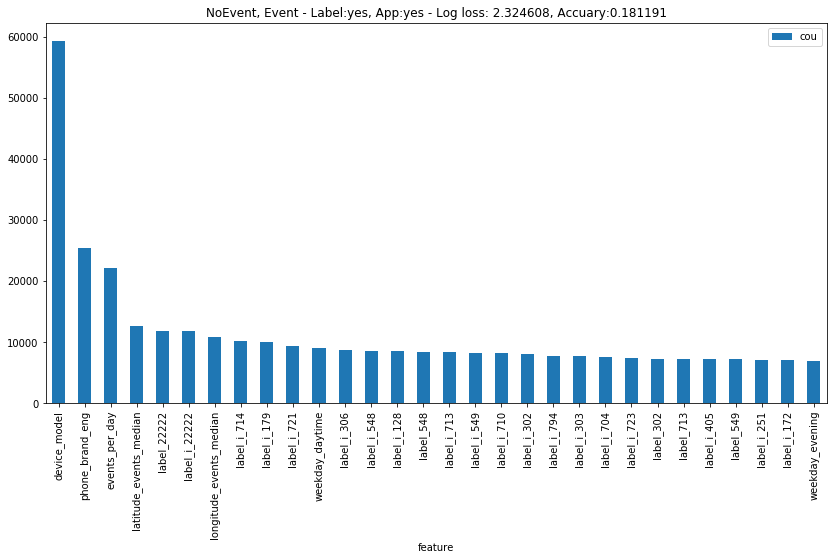

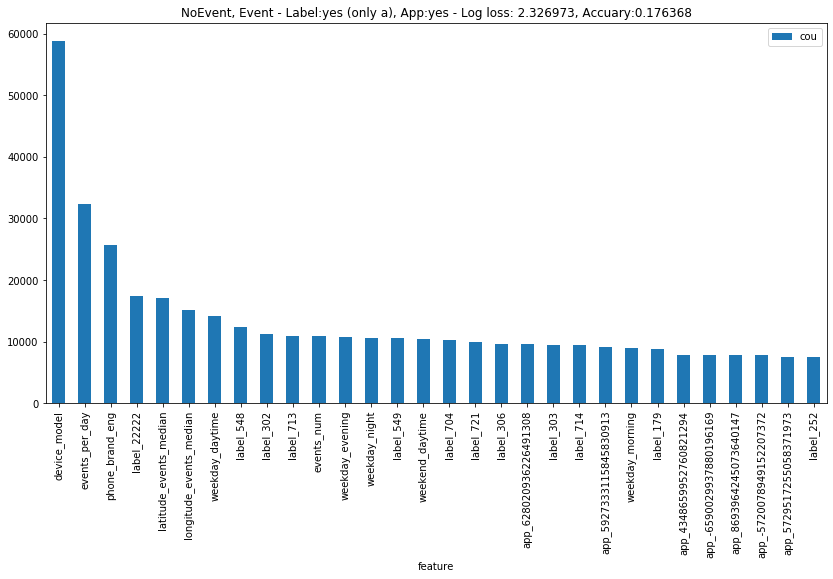

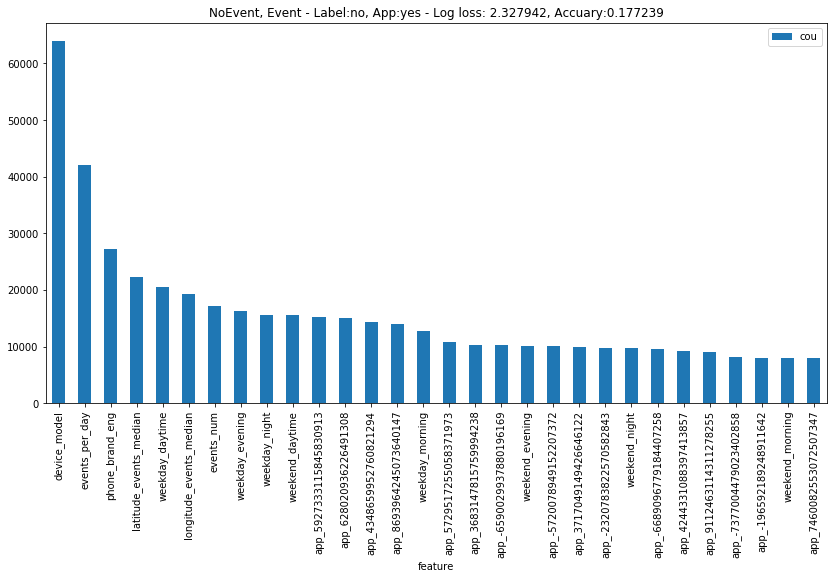

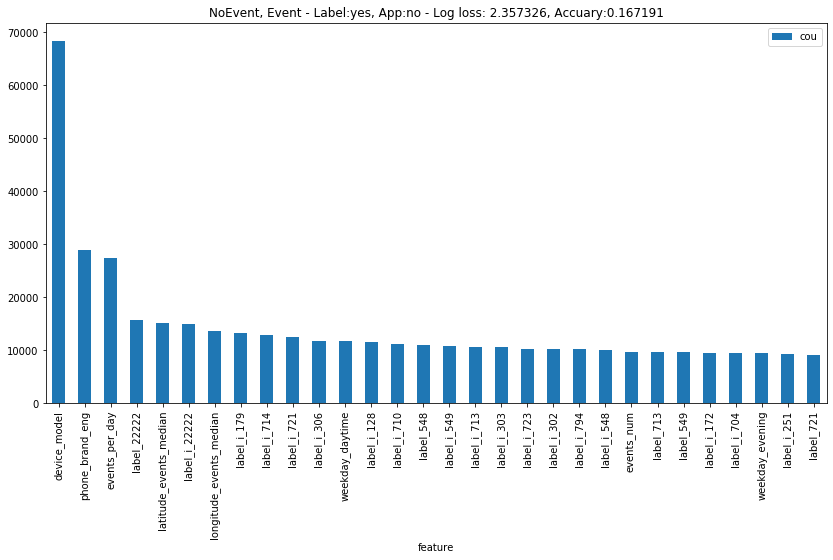

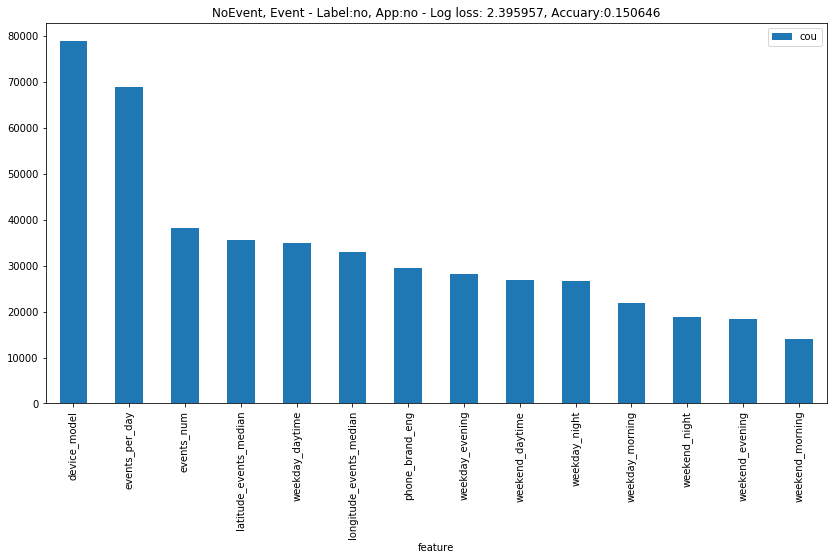

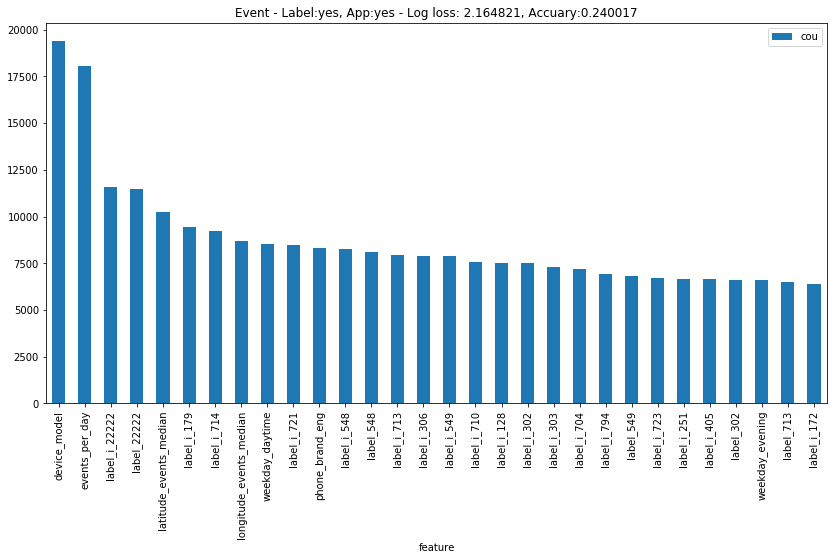

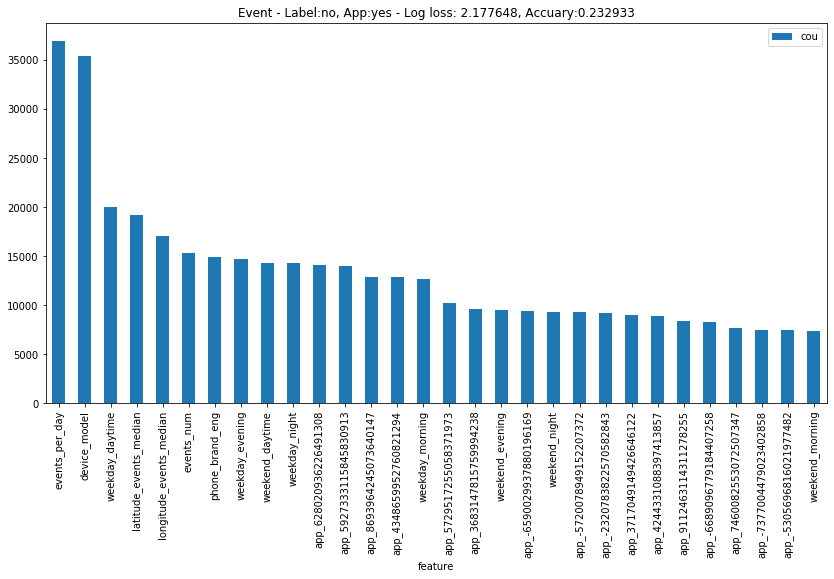

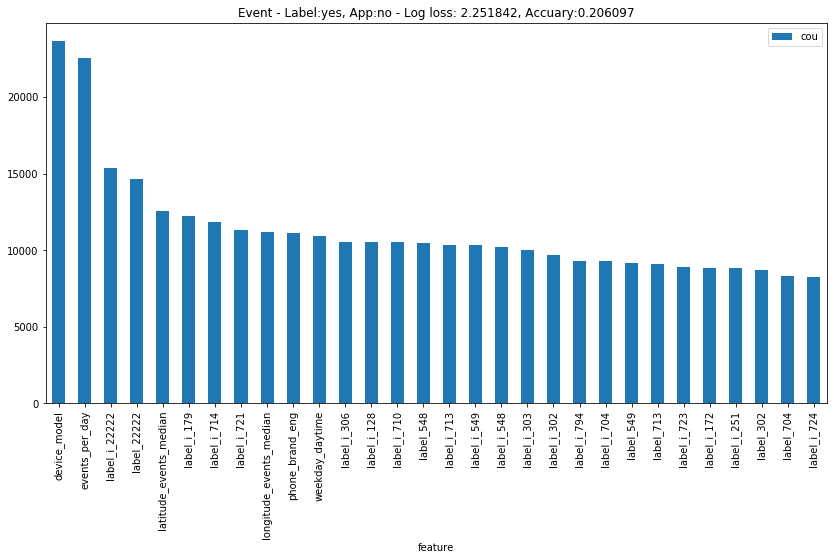

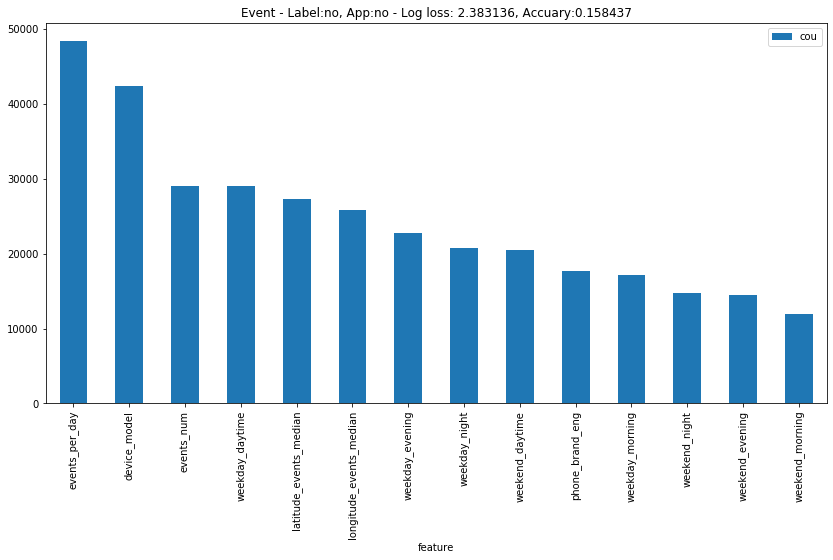

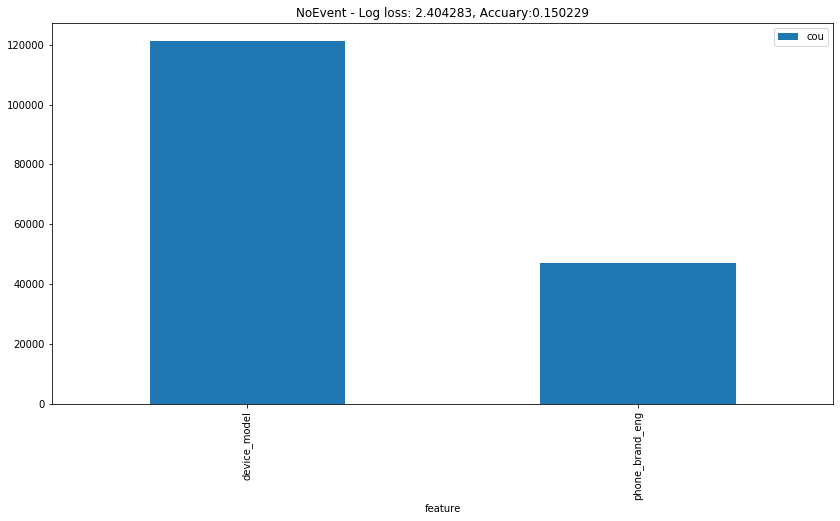

In [10]:

for i in results:
    print("%s - Log loss: %f, Accuary:%f"%(i, results[i][1], results[i][2]))
    importance = results[i][0][:30]
    # Plot the feature importances of the forest
    df1 = pd.DataFrame(importance)
    df1.rename(columns={0:"feature", 1:"cou"}, inplace=True)
    df1=df1.set_index("feature")
    df1.plot.bar(title="%s - Log loss: %f, Accuary:%f"%(i,results[i][1], results[i][2]), figsize=(14, 7))

In [11]:
results2={}
results2["NoEvent, Event - Label:yes, App:yes"] = (doXGB(df_train.head(100), magyarazo_valtozok_app_label))

[0]	train-mlogloss:2.46099	eval-mlogloss:2.47173
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.43847	eval-mlogloss:2.46501
[2]	train-mlogloss:2.41446	eval-mlogloss:2.46188
[3]	train-mlogloss:2.39274	eval-mlogloss:2.45086
[4]	train-mlogloss:2.37331	eval-mlogloss:2.44672
[5]	train-mlogloss:2.35406	eval-mlogloss:2.43873
[6]	train-mlogloss:2.33399	eval-mlogloss:2.42874


/home/akos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[7]	train-mlogloss:2.31088	eval-mlogloss:2.42458
[8]	train-mlogloss:2.29326	eval-mlogloss:2.42206
[9]	train-mlogloss:2.2781	eval-mlogloss:2.41597
[10]	train-mlogloss:2.26015	eval-mlogloss:2.4142
[11]	train-mlogloss:2.24001	eval-mlogloss:2.40851
[12]	train-mlogloss:2.22496	eval-mlogloss:2.4049
[13]	train-mlogloss:2.20787	eval-mlogloss:2.40007
[14]	train-mlogloss:2.19175	eval-mlogloss:2.39425
[15]	train-mlogloss:2.17543	eval-mlogloss:2.38802
[16]	train-mlogloss:2.16081	eval-mlogloss:2.38522
[17]	train-mlogloss:2.14514	eval-mlogloss:2.38295
[18]	train-mlogloss:2.13016	eval-mlogloss:2.3796
[19]	train-mlogloss:2.11419	eval-mlogloss:2.37569
[20]	train-mlogloss:2.10011	eval-mlogloss:2.37224
[21]	train-mlogloss:2.08827	eval-mlogloss:2.36725
[22]	train-mlogloss:2.07382	eval-mlogloss:2.36147
[23]	train-mlogloss:2.05948	eval-mlogloss:2.36112
[24]	train-mlogloss:2.04399	eval-mlogloss:2.35911
[25]	train-mlogloss:2.02853	eval-mlogloss:2.3533
[26]	train-mlogloss:2.0124	eval-mlogloss:2.35198
[27]	trai

ValueError: y_true and y_pred contain different number of classes 9, 12. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 3 4 5 6 7 8 9]

In [14]:
results2

{}